In [1]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import os
os.environ.pop("CUDA_VISIBLE_DEVICES", None)
import sys, subprocess

checkpoint = "/data/ddmg/mvseg-ordering/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
print(torch.cuda.is_available())
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

True


In [2]:
from pathlib import Path
REPO_ROOT = Path("/data/ddmg/mvseg-ordering")
for path in [REPO_ROOT, REPO_ROOT / "UniverSeg", REPO_ROOT / "MultiverSeg", REPO_ROOT / "ScribblePrompt",]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

In [3]:
from experiments.dataset.mega_medical_dataset import MegaMedicalDataset
ds = MegaMedicalDataset(
    dataset_target=12,
    split='train',
    dataset_size=None,
)

No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248


In [4]:
import numpy as np
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(3, 3))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [5]:
x = ds.get_item_by_data_index(0)[0]
x = x.squeeze(0)                    # [128, 128]
x = x.unsqueeze(-1).repeat(1, 1, 3) # [128, 128, 3]
img_np = x.numpy()
predictor.set_image(img_np)


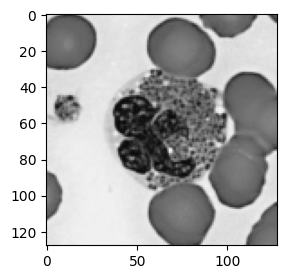

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.imshow(img_np)
plt.axis('on')
plt.show()

To select the item, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

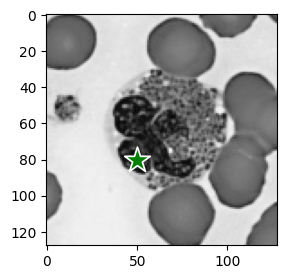

In [7]:
input_point = np.array([[50, 80]])
input_label = np.array([1])
plt.figure(figsize=(3, 3))
plt.imshow(img_np)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [8]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

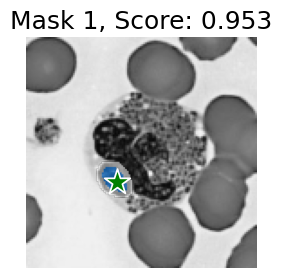

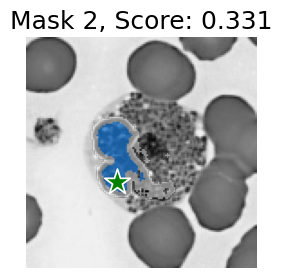

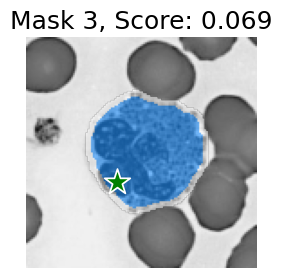

In [9]:
show_masks(img_np, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [10]:
from sam2.build_sam import build_sam2_video_predictor
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

## MegaMedical -> SAM2Video dummy context
Build a temporary JPEG-frame folder from selected MegaMedical indices, then run `SAM2VideoPredictor` with segmentation masks as dummy context prompts.


In [11]:
from pathlib import Path
import tempfile
import numpy as np
from PIL import Image

def _to_bool_mask(seg_t):
    s = seg_t.detach().cpu()
    if s.ndim == 3 and s.shape[0] == 1:
        s = s.squeeze(0)
    if s.ndim != 2:
        raise ValueError(f'Unexpected mask shape: {tuple(s.shape)}')
    return (s.numpy() > 0)


In [12]:
# Choose MegaMedical indices that will become video frames.
frame_data_indices = [0, 1, 2, 3, 4]
context_frame_count = 3  # use first N frames as dummy context

tmp_frame_dir = Path(tempfile.mkdtemp(prefix='sam2_mm_frames_'))
frame_masks = []

for frame_idx, data_idx in enumerate(frame_data_indices):
    img_t, seg_t = ds.get_item_by_data_index(data_idx)
    x = img_t.squeeze(0)                    # [128, 128]
    x = x.unsqueeze(-1).repeat(1, 1, 3) # [128, 128, 3]
    rgb = x.mul(255).byte().cpu().numpy()
    Image.fromarray(rgb).save(tmp_frame_dir / f'{frame_idx:05d}.jpg')
    mask_bool = _to_bool_mask(seg_t) if seg_t is not None else None
    frame_masks.append(mask_bool)

print('frame_dir:', tmp_frame_dir)
print('saved_frames:', len(frame_data_indices))


frame_dir: /tmp/sam2_mm_frames_lhwsd2b4
saved_frames: 5


In [18]:
from sam2.build_sam import build_sam2_video_predictor

video_predictor = build_sam2_video_predictor(model_cfg, checkpoint)
inference_state = video_predictor.init_state(video_path=str(tmp_frame_dir))
video_predictor.reset_state(inference_state)

obj_id = 1
for frame_idx in range(len(frame_masks) - 1):
    print(frame_idx)
    mask = frame_masks[frame_idx]
    if mask is None:
        continue
    video_predictor.add_new_mask(
        inference_state=inference_state,
        frame_idx=frame_idx,
        obj_id=obj_id,
        mask=mask,
    )

prop_outputs = []
for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state):
    prop_outputs.append((out_frame_idx, out_obj_ids, out_mask_logits.detach().cpu(), frame_masks[out_frame_idx]))

print('propagated_frames:', len(prop_outputs))
if prop_outputs:
    print('first_output_obj_ids:', prop_outputs[0][1])


frame loading (JPEG): 100%|██████████| 5/5 [00:00<00:00, 29.71it/s]


0
1
2
3


propagate in video: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

propagated_frames: 5
first_output_obj_ids: [1]


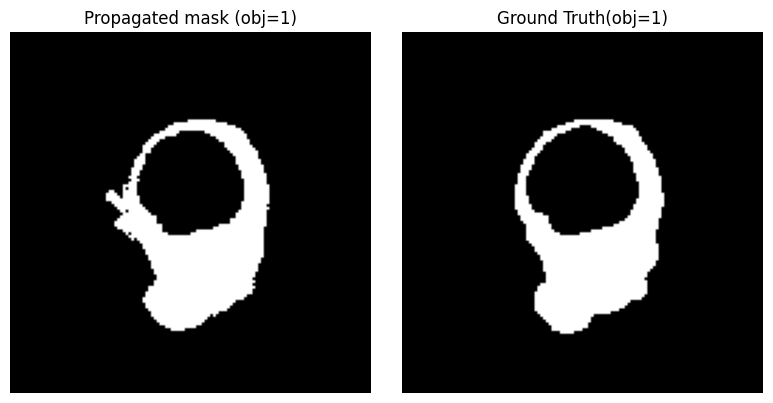

(128, 128)
tensor(0.9267)


In [20]:
# Quick sanity visualization for the first propagated frame.
import matplotlib.pyplot as plt

if not prop_outputs:
    print('No propagation outputs.')
else:
    frame_idx, obj_ids, mask_logits, gt = prop_outputs[4]
    pred_mask = (mask_logits[0] > 0).squeeze().numpy()

    frame_rgb = np.array(Image.open(tmp_frame_dir / f'{frame_idx:05d}.jpg'))
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # axes[0].set_title(f'Frame {frame_idx}')
    # axes[0].imshow(frame_rgb)
    # axes[0].axis('off')

    axes[0].set_title(f'Propagated mask (obj={obj_ids[0] if len(obj_ids) else 1})')
    axes[0].imshow(pred_mask, cmap='gray')
    axes[0].axis('off')

    axes[1].set_title(f'Ground Truth(obj={obj_ids[0] if len(obj_ids) else 1})')
    axes[1].imshow(gt, cmap='gray')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(pred_mask.shape)
    from experiments.score.dice_score import dice_score
    print(dice_score(torch.from_numpy(gt), torch.from_numpy(pred_mask)))
